Imports

In [2]:
import numpy as np
np.random.seed = 42

In [3]:
import lambeq as lq
parser = lq.BobcatParser()

In [4]:
import gensim.downloader as api
word_vectors = api.load("glove-wiki-gigaword-50")

In [5]:
from lambeq import Rewriter
from lambeq import UnifyCodomainRewriter
from lambeq import AtomicType
from lambeq import IQPAnsatz

In [6]:
from pytket.extensions.qiskit import tk_to_qiskit
from qiskit_algorithms.utils import algorithm_globals
algorithm_globals.random_seed = 42
from qiskit import QuantumCircuit
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.primitives import StatevectorEstimator
from qiskit.primitives import StatevectorSampler

In [7]:
from scipy.optimize import minimize 

Function to get a parameter given a word

In [15]:
def get_param_for_word(word):
    try:
        return np.linalg.norm(word_vectors[word.lower()]) 
    except KeyError:
        return (np.random.uniform(-1, 1, 1)[0])

Discocat implementation for sentence encoding

In [134]:
def sentence_encoder(sentence):
    diagram = parser.sentence2diagram(sentence)

    rewriter = Rewriter(['prepositional_phrase', 'determiner', 'auxiliary'])
    rewritten_diagram = rewriter(diagram)

    normalised_diagram = rewritten_diagram.normal_form()

    
    N = AtomicType.NOUN
    S = AtomicType.SENTENCE
    
    rewriter = UnifyCodomainRewriter(output_type=S)

    unified_diagram = rewriter(normalised_diagram)

    
    ansatz = IQPAnsatz({N: 2, S: 2}, n_layers=5)
    circuit = ansatz(unified_diagram)


    tket_circuit = circuit.to_tk()
    qiskit_circuit = tk_to_qiskit(tket_circuit)


    params = {}
    param_type = {'input':[], 'weight':[]}
    for i in qiskit_circuit.parameters:
        if(i._name[-1]=='0'):
            params[i] = get_param_for_word(i.name.split('_')[0])
            param_type['input'].append(i)
        else:
            params[i] = (np.random.uniform(-1, 1, 1)[0])
            param_type['weight'].append(i)

    def scale_dict_values_to_minus_one_one(d):
        min_val = min(d.values())
        max_val = max(d.values())
        
        def scale_value(x, min_val, max_val):
            return 2 * (x - min_val) / (max_val - min_val) - 1
        
        scaled_dict = {k: scale_value(v, min_val, max_val) for k, v in d.items()}
        return scaled_dict

    scaled_params = scale_dict_values_to_minus_one_one(params)
    sampler_qnn = SamplerQNN(circuit=qiskit_circuit, input_params=param_type['input'], weight_params=param_type['weight'])
    sampler_qnn_input = []
    sampler_qnn_weights = []
    for i in sampler_qnn.input_params:
        sampler_qnn_input.append(params[i])
    for i in sampler_qnn.weight_params:
        sampler_qnn_weights.append(params[i])

    def cost_function(weights):
        output_probs = sampler_qnn.forward(sampler_qnn_input, weights)
        prob_zero_state = output_probs[0][0]
        # The cost should be minimized, so we penalize 1 - the probability of |00...0⟩
        #return (1 - prob_zero_state)
        return -np.log(prob_zero_state)
    
    optimized_weights = minimize(fun=cost_function, x0=sampler_qnn_weights, method='COBYLA')
    
    optimized_params = {}
    indx = 0
    for i in param_type['input']:
        optimized_params[i] = sampler_qnn_input[indx]
        indx+=1

    indx = 0
    for i in param_type['weight']:
        optimized_params[i] = optimized_weights.x[indx]
        indx+=1
    
    sampler_qnn_forward = sampler_qnn.forward(sampler_qnn_input, optimized_weights.x)

    qubitdat = {"measured":[], "unmeasured":[]}
    for i in qiskit_circuit.data:
        if (i.operation.name == 'measure'):
            qubitdat["measured"].append(i.qubits[0]._index)



    for i in range(qiskit_circuit.num_qubits):
        if(i not in qubitdat['measured']):
            qubitdat['unmeasured'].append(i)
    
    observables = []
    n = qiskit_circuit.num_qubits
    for i in qubitdat['unmeasured']:
        observables.append('I'*i+'Z'+'I'*(n-i-1))
        observables.append('I'*i+'Y'+'I'*(n-i-1))
    observables = SparsePauliOp(observables)
    opt_qis_circ = qiskit_circuit.assign_parameters(optimized_params,inplace=False)
    estimator = StatevectorEstimator()
    pass_manager = generate_preset_pass_manager(optimization_level=3)
    isa_circuit = pass_manager.run(opt_qis_circ)
    qc_no_measure = QuantumCircuit(isa_circuit.num_qubits)

    for instruction, qubits, clbits in isa_circuit:
        if instruction.name != "measure":
            qc_no_measure.append(instruction, qubits, clbits)

    isa_observables = observables.apply_layout(isa_circuit.layout)
    pubs = [(qc_no_measure, isa_observable) for isa_observable in isa_observables]
    job = estimator.run(pubs)
    res = job.result()
    encoded_vect_for_sentence = []

    for i in res:
        encoded_vect_for_sentence.append(i.data.evs)
    return encoded_vect_for_sentence

In [135]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = float(line[0])
            labels.append(t)
            sentences.append(line[1:].strip())
    return labels, sentences


In [136]:
train_labels, train_data = read_data('dataset/train.txt')
test_labels, test_data = read_data('dataset/test.txt')

In [137]:
#this will take a long time to compute if you decide to run it
train_data_vector = [sentence_encoder(s) for s in train_data]
test_data_vector = [sentence_encoder(s) for s in test_data]
train_features = np.array(train_data_vector)
test_features = np.array(test_data_vector)


In [138]:
import pandas as pd
df1 = pd.DataFrame(train_features)
df2 = pd.DataFrame(test_features)
df1.to_csv('dataset/train_features.csv')
df2.to_csv('dataset/test_features.csv')

step by step code demonstration of sentence encode function

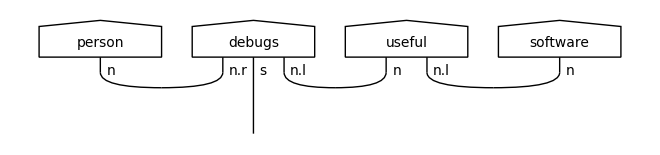

In [8]:
diagram = parser.sentence2diagram("person debugs useful software")
diagram.draw()

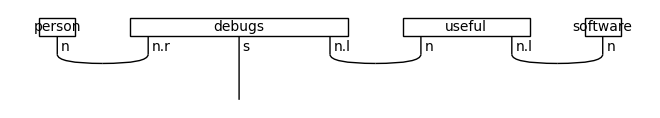

In [9]:
rewriter = Rewriter(['prepositional_phrase', 'determiner', 'auxiliary'])
rewritten_diagram = rewriter(diagram)

normalised_diagram = rewritten_diagram.normal_form()

normalised_diagram.draw()

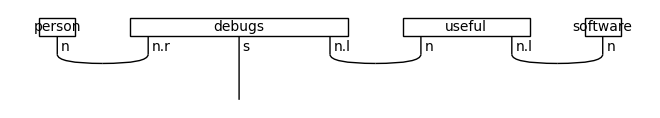

In [10]:
N = AtomicType.NOUN
S = AtomicType.SENTENCE
    
rewriter = UnifyCodomainRewriter(output_type=S)
unified_diagram = rewriter(normalised_diagram)
unified_diagram.draw()

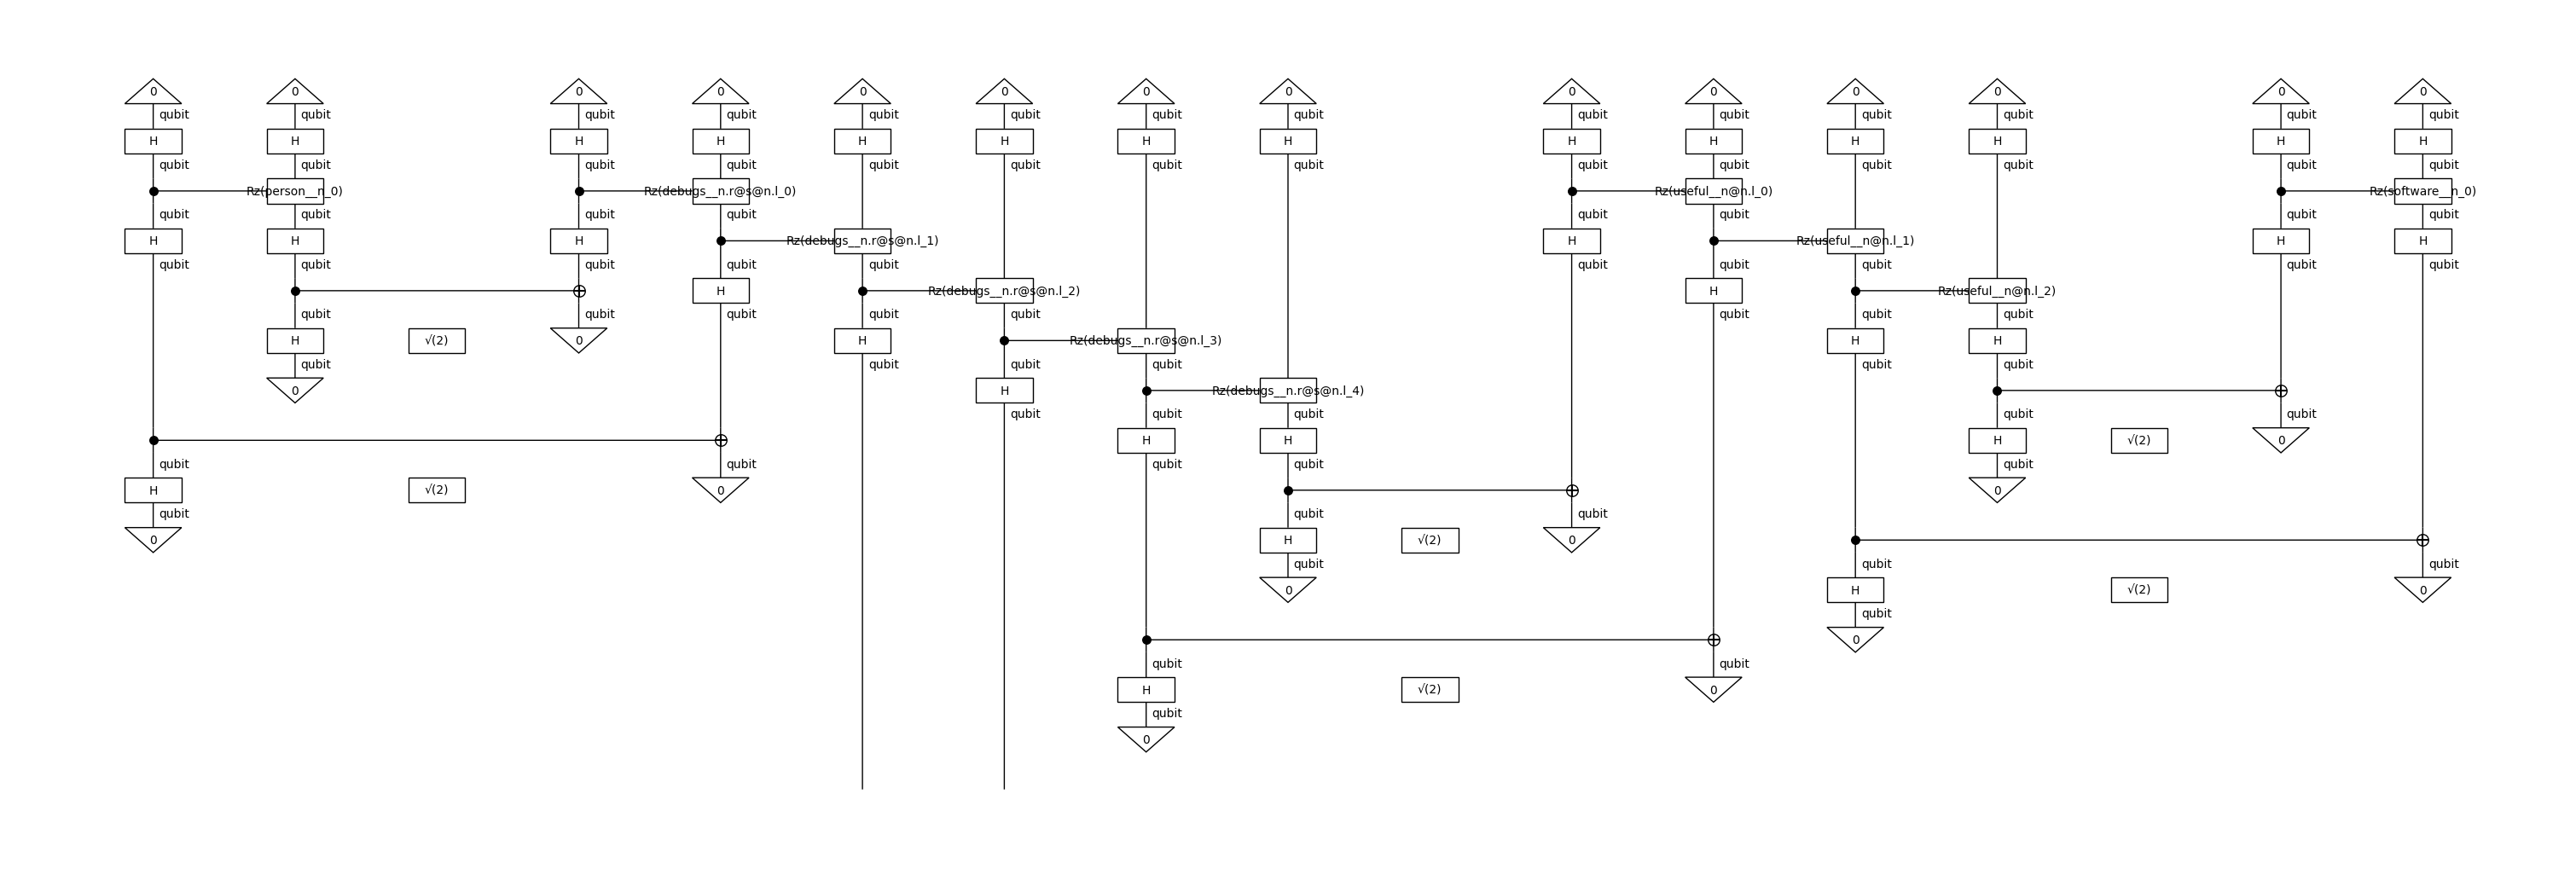

In [11]:
ansatz = IQPAnsatz({N: 2, S: 2}, n_layers=1)
circuit = ansatz(unified_diagram)
circuit.draw(figsize=(30,10) )

In [12]:
from pytket.extensions.qiskit import tk_to_qiskit
from qiskit_algorithms.utils import algorithm_globals
algorithm_globals.random_seed = 564
from qiskit import QuantumCircuit
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.primitives import StatevectorEstimator
from qiskit.primitives import StatevectorSampler

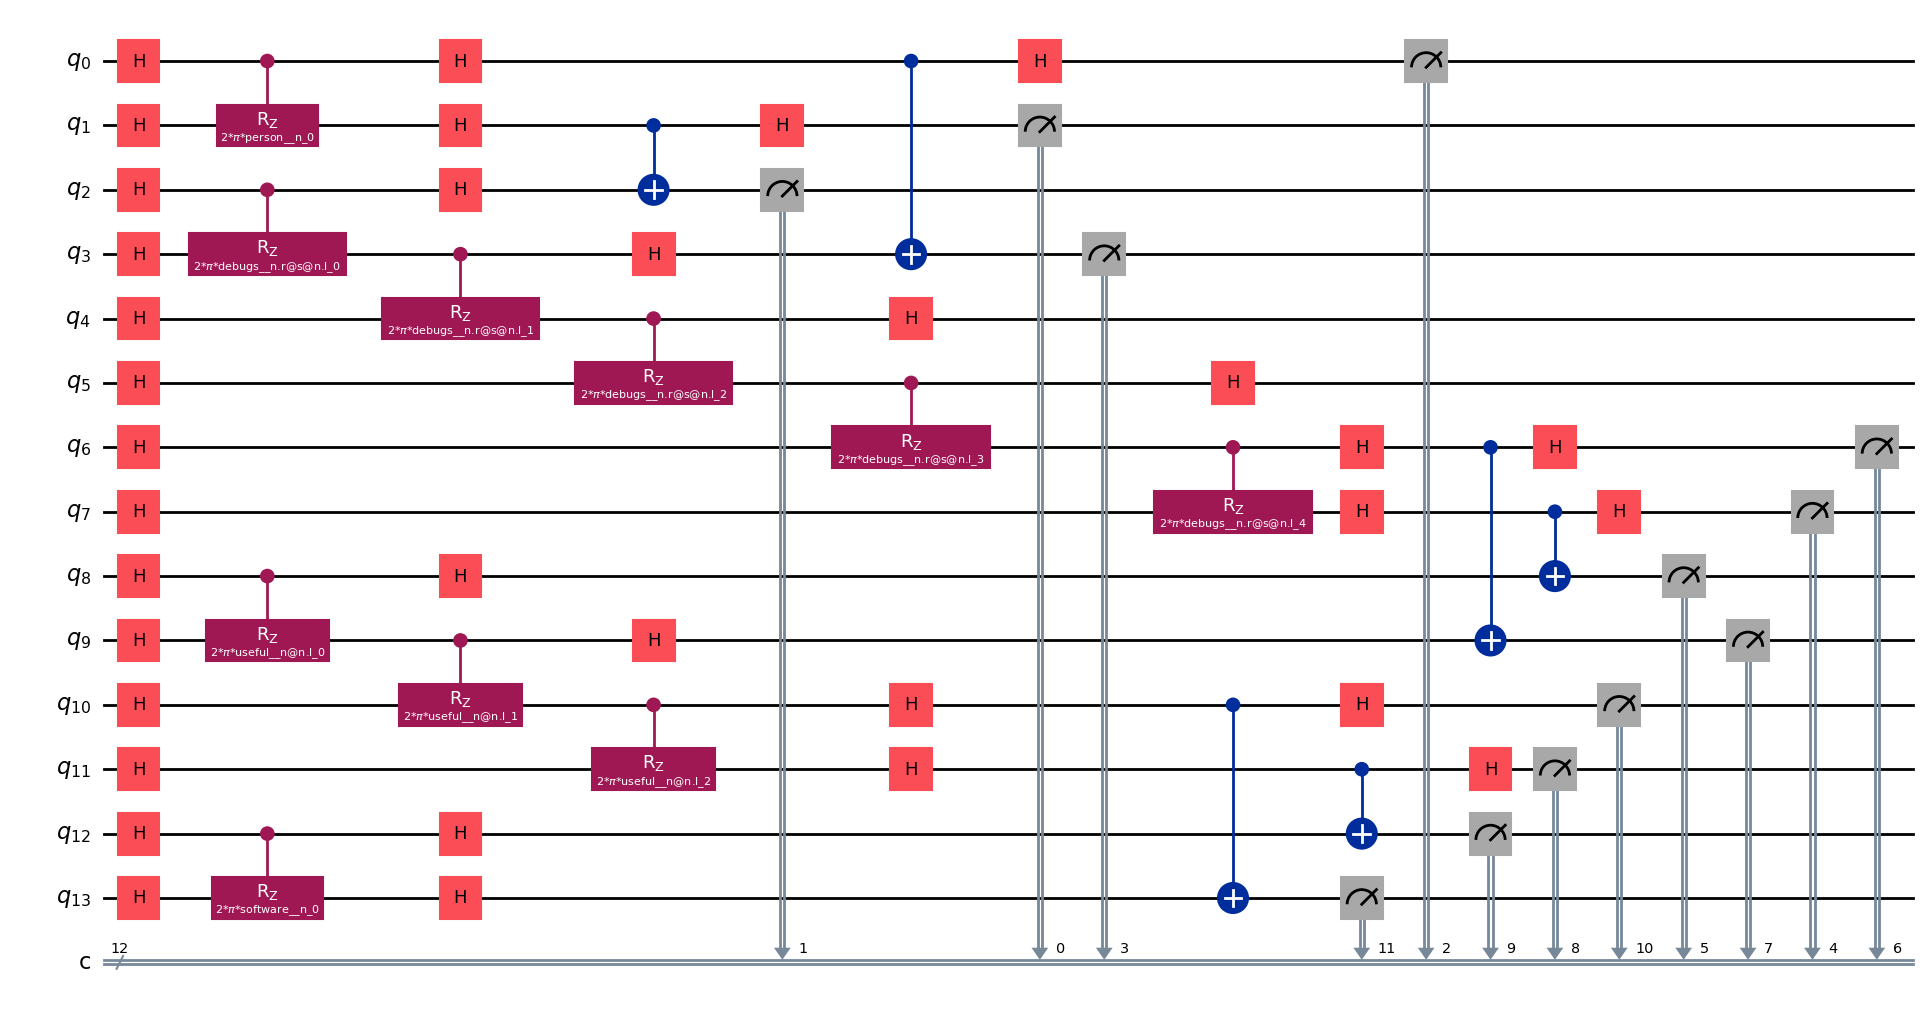

In [13]:
tket_circuit = circuit.to_tk()
qiskit_circuit = tk_to_qiskit(tket_circuit)
qiskit_circuit.draw("mpl", fold=40)

seperating input parameters and weight parameters

In [16]:
params = {}
param_type = {'input':[], 'weight':[]}
for i in qiskit_circuit.parameters:
    if(i._name[-1]=='0'):
        params[i] = get_param_for_word(i.name.split('_')[0])
        param_type['input'].append(i)
    else:
        params[i] = (np.random.uniform(-1, 1, 1)[0])
        param_type['weight'].append(i)

def scale_dict_values_to_minus_one_one(d):
    min_val = min(d.values())
    max_val = max(d.values())
    
    def scale_value(x, min_val, max_val):
        return 2 * (x - min_val) / (max_val - min_val) - 1
    
    scaled_dict = {k: scale_value(v, min_val, max_val) for k, v in d.items()}
    return scaled_dict

get values of inputs and weights

In [17]:
scaled_params = scale_dict_values_to_minus_one_one(params)
sampler_qnn = SamplerQNN(circuit=qiskit_circuit, input_params=param_type['input'], weight_params=param_type['weight'])
sampler_qnn_input = []
sampler_qnn_weights = []
for i in sampler_qnn.input_params:
    sampler_qnn_input.append(params[i])
for i in sampler_qnn.weight_params:
    sampler_qnn_weights.append(params[i])

cost function

In [18]:
def cost_function(weights):
    output_probs = sampler_qnn.forward(sampler_qnn_input, weights)
    prob_zero_state = output_probs[0][0]
    # The cost should be minimized, so we penalize 1 - the probability of |00...0⟩
    #return (1 - prob_zero_state)
    return -np.log(prob_zero_state)

In [19]:
optimized_weights = minimize(fun=cost_function, x0=sampler_qnn_weights, method='COBYLA')
    
optimized_params = {}
indx = 0
for i in param_type['input']:
    optimized_params[i] = sampler_qnn_input[indx]
    indx+=1

indx = 0
for i in param_type['weight']:
    optimized_params[i] = optimized_weights.x[indx]
    indx+=1
    

In [20]:
sampler_qnn_forward = sampler_qnn.forward(sampler_qnn_input, optimized_weights.x)

In [21]:
qubitdat = {"measured":[], "unmeasured":[]}
for i in qiskit_circuit.data:
    if (i.operation.name == 'measure'):
        qubitdat["measured"].append(i.qubits[0]._index)



for i in range(qiskit_circuit.num_qubits):
    if(i not in qubitdat['measured']):
        qubitdat['unmeasured'].append(i)

In [22]:
observables = []
n = qiskit_circuit.num_qubits
for i in qubitdat['unmeasured']:
    observables.append('I'*i+'Z'+'I'*(n-i-1))
    observables.append('I'*i+'Y'+'I'*(n-i-1))
observables = SparsePauliOp(observables)
opt_qis_circ = qiskit_circuit.assign_parameters(optimized_params,inplace=False)
estimator = StatevectorEstimator()
pass_manager = generate_preset_pass_manager(optimization_level=3)
isa_circuit = pass_manager.run(opt_qis_circ)
qc_no_measure = QuantumCircuit(isa_circuit.num_qubits)

In [24]:
for instruction, qubits, clbits in isa_circuit:
    if instruction.name != "measure":
        qc_no_measure.append(instruction, qubits, clbits)

isa_observables = observables.apply_layout(isa_circuit.layout)
pubs = [(qc_no_measure, isa_observable) for isa_observable in isa_observables]
job = estimator.run(pubs)
res = job.result()
encoded_vect_for_sentence = []
for i in res:
    encoded_vect_for_sentence.append(i.data.evs)

encoded value

In [25]:
encoded_vect_for_sentence

[array(-0.00294856),
 array(0.00981573),
 array(-1.39658792e-17),
 array(0.07829689)]